# Test spikes?

Liang: Spikes in Observations: The observed fluxes show more spikes compared to the simulations. Are these real? How is energy closure handled in these data? If these spikes are real, you could use specific statistical metrics to evaluate how well the model captures these peak values. There are methods available to assess this aspect of model performance.


# code OK （only method 1： 3 sigma method）

Spike Analysis for LH:
  Observed: spikes = 1131, Mean amplitude = 357.87, σ = 91.78, 1σ = 143.25, 2σ = 235.02, 3σ = 326.80
  Modeled:  spikes = 1462, Mean amplitude = 229.18, σ = 50.84, 1σ = 81.20, 2σ = 132.04, 3σ = 182.88

Spike Analysis for SH:
  Observed: spikes = 1228, Mean amplitude = 392.19, σ = 101.26, 1σ = 130.39, 2σ = 231.65, 3σ = 332.91
  Modeled:  spikes = 1487, Mean amplitude = 511.81, σ = 123.94, 1σ = 188.50, 2σ = 312.44, 3σ = 436.37

Spike Analysis for GPP:
  Observed: spikes = 1905, Mean amplitude = 20.56, σ = 5.09, 1σ = 7.48, 2σ = 12.57, 3σ = 17.65
  Modeled:  spikes = 1466, Mean amplitude = 24.15, σ = 5.92, 1σ = 9.09, 2σ = 15.02, 3σ = 20.94



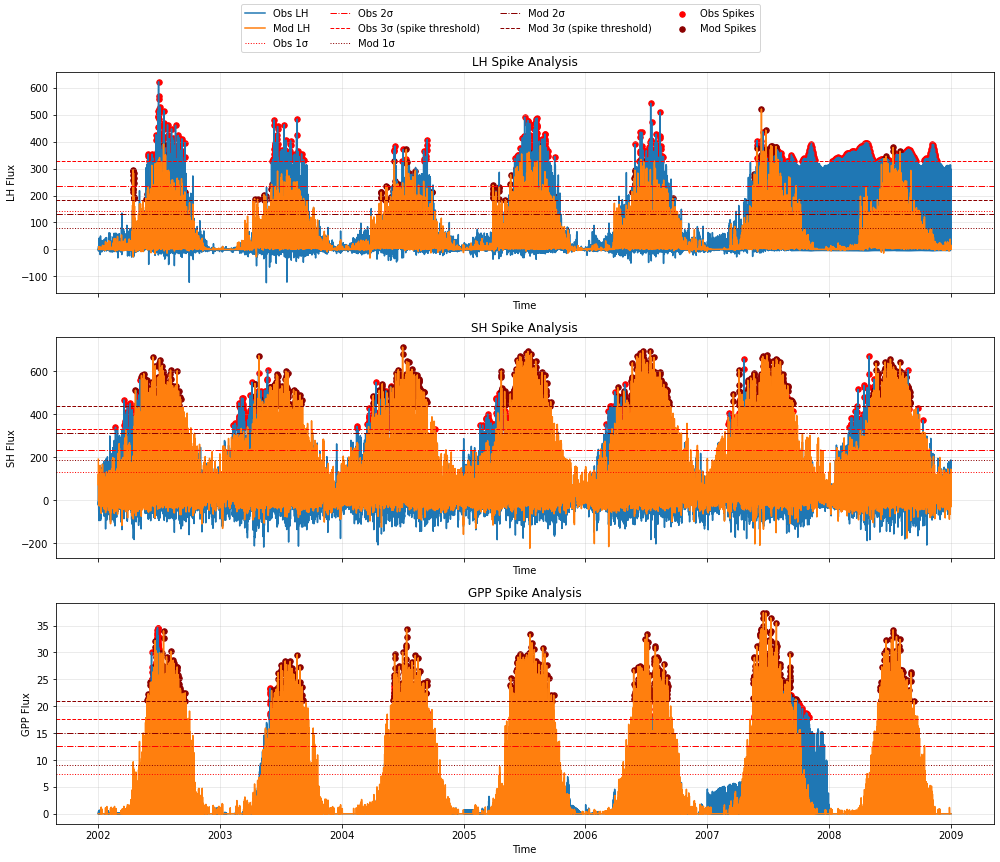

In [3]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np

# -----------------------------
# Data Processing Functions
# -----------------------------
def process_latent_heat_data(obs_file: str) -> pd.DataFrame:
    """Process observation data for latent heat."""
    ds = xr.open_dataset(obs_file)
    # Convert time if stored as numbers (e.g., 2002010106)
    if isinstance(ds.time.values[0], np.floating):
        times = pd.to_datetime([f"{int(t):010d}" for t in ds.time.values],
                               format='%Y%m%d%H')
        ds['time'] = times
    return ds['Qle_cor'].to_dataframe()

def process_sensible_heat_data(flux_file: str) -> pd.DataFrame:
    """Process observation data for sensible heat."""
    ds = xr.open_dataset(flux_file)
    if isinstance(ds.time.values[0], np.floating):
        times = pd.to_datetime([f"{int(t):010d}" for t in ds.time.values],
                               format='%Y%m%d%H')
        ds['time'] = times
    return pd.DataFrame({'Qh': ds['Qh_cor'].values}, index=ds.time.values)

def process_gpp_data(flux_file: str) -> pd.DataFrame:
    """Process observation data for GPP."""
    ds = xr.open_dataset(flux_file)
    if isinstance(ds.time.values[0], np.floating):
        times = pd.to_datetime([f"{int(t):010d}" for t in ds.time.values],
                               format='%Y%m%d%H')
        ds['time'] = times
    return pd.DataFrame({'GPP': ds['GPP_DT'].values}, index=ds.time.values)

def process_model_data(mod_file: str) -> tuple:
    """
    Process model data for LH, Sensible Heat (HFX), and GPP proxy (PSN).
    The 'Times' variable is assumed to be in bytes and decoded to a string.
    """
    ds = xr.open_dataset(mod_file)
    times = [datetime.strptime(t.decode('utf-8'), '%Y-%m-%d_%H:%M:%S')
             for t in ds['Times'].values]
    df_lh = pd.DataFrame({'LH': ds['LH'][:, 0, 0].values}, index=times)
    df_sh = pd.DataFrame({'HFX': ds['HFX'][:, 0, 0].values}, index=times)
    df_psn = pd.DataFrame({'PSN': ds['PSN'][:, 0, 0].values}, index=times)
    return df_lh, df_sh, df_psn

# -----------------------------
# Spike Detection and Plotting
# -----------------------------
def detect_spikes(series: pd.Series):
    """
    Identify spikes defined as any point > (mean + 3 * std).
    Returns:
      - spike_indices: the index labels of spikes
      - spike_values: the spike amplitudes
      - mean_val: the mean of the series
      - sigma: standard deviation
      - threshold: mean + 3 * sigma
    """
    mean_val = series.mean()
    sigma = series.std()
    threshold = mean_val + 3 * sigma
    spike_mask = series > threshold
    spike_indices = series.index[spike_mask]
    spike_values = series[spike_mask]
    return spike_indices, spike_values, mean_val, sigma, threshold

def plot_variable_spikes(ax, obs_series: pd.Series, mod_series: pd.Series, var_name: str, show_labels: bool = False):
    """
    Plot the time series for a given variable along with spike analysis.
    - Plots the observed series (blue) and modeled series (orange).
    - Draws horizontal lines at mean+1σ (dotted), mean+2σ (dash-dot), and mean+3σ (dashed)
      separately for obs (red) and mod (darkred).
    - Overlays spike markers (points above the 3σ threshold) in red colors.
    - Prints spike statistics to the console.
    """
    # --- Observed Data ---
    obs_spike_idx, obs_spike_vals, obs_mean, obs_sigma, obs_thresh = detect_spikes(obs_series)
    obs_T1 = obs_mean + 1 * obs_sigma
    obs_T2 = obs_mean + 2 * obs_sigma
    # obs_T3 is the spike threshold = obs_mean + 3σ

    # --- Modeled Data ---
    mod_spike_idx, mod_spike_vals, mod_mean, mod_sigma, mod_thresh = detect_spikes(mod_series)
    mod_T1 = mod_mean + 1 * mod_sigma
    mod_T2 = mod_mean + 2 * mod_sigma
    # mod_T3 is the spike threshold = mod_mean + 3σ

    # Plot the time series lines
    ax.plot(obs_series.index, obs_series.values, color='#1f77b4', label=f'Obs {var_name}')
    ax.plot(mod_series.index, mod_series.values, color='#ff7f0e', label=f'Mod {var_name}')

    # Plot threshold lines for observed (red shades)
    ax.axhline(obs_T1, color='red', linestyle=':', linewidth=1,
               label='Obs 1σ' if show_labels else None)
    ax.axhline(obs_T2, color='red', linestyle='-.', linewidth=1,
               label='Obs 2σ' if show_labels else None)
    ax.axhline(obs_thresh, color='red', linestyle='--', linewidth=1,
               label='Obs 3σ (spike threshold)' if show_labels else None)

    # Plot threshold lines for modeled (darkred shades)
    ax.axhline(mod_T1, color='darkred', linestyle=':', linewidth=1,
               label='Mod 1σ' if show_labels else None)
    ax.axhline(mod_T2, color='darkred', linestyle='-.', linewidth=1,
               label='Mod 2σ' if show_labels else None)
    ax.axhline(mod_thresh, color='darkred', linestyle='--', linewidth=1,
               label='Mod 3σ (spike threshold)' if show_labels else None)

    # Overlay spike markers (using distinct red colors)
    ax.scatter(obs_spike_idx, obs_spike_vals, color='red', marker='o', s=30,
               label='Obs Spikes' if show_labels else None)
    ax.scatter(mod_spike_idx, mod_spike_vals, color='darkred', marker='o', s=30,
               label='Mod Spikes' if show_labels else None)

    # Axis formatting
    ax.set_title(f'{var_name} Spike Analysis')
    ax.set_xlabel('Time')
    ax.set_ylabel(f'{var_name} Flux')
    ax.grid(True, alpha=0.3)

    # Print spike analysis results to console
    num_obs_spikes = len(obs_spike_idx)
    mean_obs_spike = obs_spike_vals.mean() if num_obs_spikes > 0 else np.nan

    num_mod_spikes = len(mod_spike_idx)
    mean_mod_spike = mod_spike_vals.mean() if num_mod_spikes > 0 else np.nan

    print(f"Spike Analysis for {var_name}:")
    print(f"  Observed: spikes = {num_obs_spikes}, Mean amplitude = {mean_obs_spike:.2f}, "
          f"σ = {obs_sigma:.2f}, 1σ = {obs_T1:.2f}, 2σ = {obs_T2:.2f}, 3σ = {obs_thresh:.2f}")
    print(f"  Modeled:  spikes = {num_mod_spikes}, Mean amplitude = {mean_mod_spike:.2f}, "
          f"σ = {mod_sigma:.2f}, 1σ = {mod_T1:.2f}, 2σ = {mod_T2:.2f}, 3σ = {mod_thresh:.2f}\n")

# -----------------------------
# Main Routine: Build Simple Figure
# -----------------------------
def main():
    # File paths (adjust as needed)
    FLUX_FILE = "../obs/US-Syv_2002010106_2009010105_hur_Flux.nc"
    MOD_FILE  = "../US-Syv_01/2002010107.LDASOUT_DOMAIN1"
    
    # Load observation data
    df_obs_lh = process_latent_heat_data(FLUX_FILE)
    df_obs_sh = process_sensible_heat_data(FLUX_FILE)
    df_obs_gpp = process_gpp_data(FLUX_FILE)
    
    # Load model data
    df_mod_lh, df_mod_sh, df_mod_psn = process_model_data(MOD_FILE)
    
    # (Optional) Limit observations to model period if needed
    max_time = min(df_mod_lh.index.max(), df_mod_sh.index.max(), df_mod_psn.index.max())
    df_obs_lh = df_obs_lh[df_obs_lh.index <= max_time]
    df_obs_sh = df_obs_sh[df_obs_sh.index <= max_time]
    df_obs_gpp = df_obs_gpp[df_obs_gpp.index <= max_time]
    
    # Create a figure with 3 subplots (one column)
    fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
    
    # For the first subplot (LH), include full legend labels
    plot_variable_spikes(axes[0],
                           obs_series=df_obs_lh['Qle_cor'],
                           mod_series=df_mod_lh['LH'],
                           var_name="LH",
                           show_labels=True)
    
    # Second subplot: Sensible Heat (SH)
    plot_variable_spikes(axes[1],
                           obs_series=df_obs_sh['Qh'],
                           mod_series=df_mod_sh['HFX'],
                           var_name="SH",
                           show_labels=False)
    
    # Third subplot: GPP (use observation from GPP and model from PSN)
    plot_variable_spikes(axes[2],
                           obs_series=df_obs_gpp['GPP'],
                           mod_series=df_mod_psn['PSN'],
                           var_name="GPP",
                           show_labels=False)
    
    # Place a common legend (only once)
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=4, frameon=True)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

if __name__ == '__main__':
    main()


# test more times
下面给出一个新的 detect_spikes() 函数版本，该函数新增一个整型参数 method，取值 1～6 分别对应下面列出的 6 种检测方法：

method=1：基于全局均值和标准差的 “mean+3σ” 方法
method=2：Z-score 方法（默认阈值为 3）
method=3：基于中位数和 MAD 的方法（默认阈值 3.5）
method=4：基于局部（滚动）均值和标准差的方法（默认窗口 24，阈值 3）
method=5：利用 scikit-learn 的 IsolationForest 方法（默认污染率 0.01）
method=6：利用 SciPy 的 find_peaks() 方法（默认 prominence=1.0）
下面是新的 detect_spikes() 函数代码：

In [4]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np

# -----------------------------
# Data Processing Functions
# -----------------------------
def process_latent_heat_data(obs_file: str) -> pd.DataFrame:
    """Process observation data for latent heat."""
    ds = xr.open_dataset(obs_file)
    # Convert time if stored as numbers (e.g., 2002010106)
    if isinstance(ds.time.values[0], np.floating):
        times = pd.to_datetime([f"{int(t):010d}" for t in ds.time.values],
                               format='%Y%m%d%H')
        ds['time'] = times
    return ds['Qle_cor'].to_dataframe()

def process_sensible_heat_data(flux_file: str) -> pd.DataFrame:
    """Process observation data for sensible heat."""
    ds = xr.open_dataset(flux_file)
    if isinstance(ds.time.values[0], np.floating):
        times = pd.to_datetime([f"{int(t):010d}" for t in ds.time.values],
                               format='%Y%m%d%H')
        ds['time'] = times
    return pd.DataFrame({'Qh': ds['Qh_cor'].values}, index=ds.time.values)

def process_gpp_data(flux_file: str) -> pd.DataFrame:
    """Process observation data for GPP."""
    ds = xr.open_dataset(flux_file)
    if isinstance(ds.time.values[0], np.floating):
        times = pd.to_datetime([f"{int(t):010d}" for t in ds.time.values],
                               format='%Y%m%d%H')
        ds['time'] = times
    return pd.DataFrame({'GPP': ds['GPP_DT'].values}, index=ds.time.values)

def process_model_data(mod_file: str) -> tuple:
    """
    Process model data for LH, Sensible Heat (HFX), and GPP proxy (PSN).
    The 'Times' variable is assumed to be in bytes and decoded to a string.
    """
    ds = xr.open_dataset(mod_file)
    times = [datetime.strptime(t.decode('utf-8'), '%Y-%m-%d_%H:%M:%S')
             for t in ds['Times'].values]
    df_lh = pd.DataFrame({'LH': ds['LH'][:, 0, 0].values}, index=times)
    df_sh = pd.DataFrame({'HFX': ds['HFX'][:, 0, 0].values}, index=times)
    df_psn = pd.DataFrame({'PSN': ds['PSN'][:, 0, 0].values}, index=times)
    return df_lh, df_sh, df_psn

def detect_spikes(series: pd.Series, method: int = 1, **kwargs):
    """
    Detect spikes in a time series using different methods.
    
    Parameters:
        series : pd.Series
            要检测的时间序列数据。
        method : int, default=1
            选择检测方法：
              1 - 全局均值+3σ 方法
              2 - Z-score 方法（默认阈值 3）
              3 - MAD 方法（默认阈值 3.5）
              4 - 滚动统计方法（默认窗口 24，阈值 3）
              5 - IsolationForest 方法（默认 contamination=0.01）
              6 - scipy.signal.find_peaks 方法（默认 prominence=1.0）
        **kwargs : dict
            各方法的额外参数，例如 threshold、window、contamination、prominence 等。
    
    Returns:
        spike_indices : Index
            被检测为“spike”的时间索引。
        spike_values : pd.Series
            对应的数值。
        extra_info : dict
            其他附加信息，例如计算得到的均值、σ、阈值等。
    """
    if method == 1:
        # 方法1：均值+3σ
        mean_val = series.mean()
        sigma = series.std()
        threshold = mean_val + 3 * sigma
        spike_mask = series > threshold
        spike_indices = series.index[spike_mask]
        spike_values = series[spike_mask]
        extra_info = {'mean': mean_val, 'sigma': sigma, 'threshold': threshold, 'method': 'mean+3σ'}
        return spike_indices, spike_values, extra_info

    elif method == 2:
        # 方法2：Z-score 方法，默认阈值 3
        threshold = kwargs.get('threshold', 3.0)
        mean_val = series.mean()
        sigma = series.std()
        z_scores = (series - mean_val) / sigma
        spike_mask = abs(z_scores) > threshold
        spike_indices = series.index[spike_mask]
        spike_values = series[spike_mask]
        extra_info = {'mean': mean_val, 'sigma': sigma, 'z_threshold': threshold, 'method': 'zscore'}
        return spike_indices, spike_values, extra_info

    elif method == 3:
        # 方法3：MAD 方法，默认阈值 3.5
        threshold = kwargs.get('threshold', 3.5)
        median = series.median()
        mad = (np.abs(series - median)).median()
        modified_z_score = 0.6745 * (series - median) / mad
        spike_mask = np.abs(modified_z_score) > threshold
        spike_indices = series.index[spike_mask]
        spike_values = series[spike_mask]
        extra_info = {'median': median, 'mad': mad, 'mad_threshold': threshold, 'method': 'MAD'}
        return spike_indices, spike_values, extra_info

    elif method == 4:
        # 方法4：滚动统计方法（局部均值+局部标准差），默认窗口 24，阈值 3
        window = kwargs.get('window', 24)
        threshold = kwargs.get('threshold', 3.0)
        roll_mean = series.rolling(window=window, center=True).mean()
        roll_std = series.rolling(window=window, center=True).std()
        spike_mask = series > (roll_mean + threshold * roll_std)
        spike_indices = series.index[spike_mask]
        spike_values = series[spike_mask]
        extra_info = {'window': window, 'threshold': threshold, 'method': 'rolling'}
        return spike_indices, spike_values, extra_info

    elif method == 5:
        # 方法5：IsolationForest 方法
        from sklearn.ensemble import IsolationForest
        contamination = kwargs.get('contamination', 0.01)
        X = series.values.reshape(-1, 1)
        clf = IsolationForest(contamination=contamination, random_state=42)
        clf.fit(X)
        preds = clf.predict(X)
        spike_mask = preds == -1
        spike_indices = series.index[spike_mask]
        spike_values = series[spike_mask]
        extra_info = {'contamination': contamination, 'method': 'IsolationForest'}
        return spike_indices, spike_values, extra_info

    elif method == 6:
        # 方法6：scipy.signal.find_peaks 方法，默认 prominence=1.0
        from scipy.signal import find_peaks
        prominence = kwargs.get('prominence', 1.0)
        peaks, properties = find_peaks(series.values, prominence=prominence)
        spike_indices = series.index[peaks]
        spike_values = series.iloc[peaks]
        extra_info = {'prominence': prominence, 'properties': properties, 'method': 'find_peaks'}
        return spike_indices, spike_values, extra_info

    else:
        raise ValueError("Invalid method. Choose an integer between 1 and 6.")


def plot_variable_spikes(ax, obs_series: pd.Series, mod_series: pd.Series, var_name: str,
                         spike_method: int = 1, spike_kwargs: dict = None, show_labels: bool = False):
    """
    绘制单个变量的时间序列及其 spike 检测结果。
    
    参数:
      - spike_method: 选择的 spike 检测方法（1～6）。
      - spike_kwargs: 传递给 detect_spikes() 的额外参数字典。
    """
    if spike_kwargs is None:
        spike_kwargs = {}

    # 观测数据的 spike 检测
    obs_spike_idx, obs_spike_vals, obs_extra = detect_spikes(obs_series, method=spike_method, **spike_kwargs)
    # 模型数据的 spike 检测
    mod_spike_idx, mod_spike_vals, mod_extra = detect_spikes(mod_series, method=spike_method, **spike_kwargs)
    
    # 绘制时间序列曲线（观测：蓝色，模型：橙色）
    ax.plot(obs_series.index, obs_series.values, color='#1f77b4', label=f'Obs {var_name}')
    ax.plot(mod_series.index, mod_series.values, color='#ff7f0e', label=f'Mod {var_name}')
    
    # 在此处为了显示阈值水平（如果方法支持全局统计，可以额外绘制），这里只作为示例，
    # 若方法返回 extra_info 包含 'threshold' 字段则绘制该水平线（用虚线）。
    if 'threshold' in obs_extra:
        ax.axhline(obs_extra['threshold'], color='red', linestyle='--', linewidth=1,
                   label='Obs Spike Threshold' if show_labels else None)
    if 'threshold' in mod_extra:
        ax.axhline(mod_extra['threshold'], color='darkred', linestyle='--', linewidth=1,
                   label='Mod Spike Threshold' if show_labels else None)
    
    # 绘制检测到的 spike 点（使用不同的红色）
    ax.scatter(obs_spike_idx, obs_spike_vals, color='red', marker='o', s=30,
               label='Obs Spikes' if show_labels else None)
    ax.scatter(mod_spike_idx, mod_spike_vals, color='darkred', marker='o', s=30,
               label='Mod Spikes' if show_labels else None)
    
    ax.set_title(f'{var_name} Spike Analysis (Method {spike_method})')
    ax.set_xlabel('Time')
    ax.set_ylabel(f'{var_name} Flux')
    ax.grid(True, alpha=0.3)
    
    # 打印检测结果（可选）
    num_obs = len(obs_spike_idx)
    num_mod = len(mod_spike_idx)
    mean_obs = obs_spike_vals.mean() if num_obs > 0 else np.nan
    mean_mod = mod_spike_vals.mean() if num_mod > 0 else np.nan
    print(f"Spike Analysis for {var_name} using method {spike_method}:")
    print(f"  Observed: spikes = {num_obs}, Mean amplitude = {mean_obs:.2f}")
    print(f"  Modeled:  spikes = {num_mod}, Mean amplitude = {mean_mod:.2f}\n")


Spike Analysis for LH using method 1:
  Observed: spikes = 1131, Mean amplitude = 357.87
  Modeled:  spikes = 1462, Mean amplitude = 229.18

Spike Analysis for SH using method 1:
  Observed: spikes = 1228, Mean amplitude = 392.19
  Modeled:  spikes = 1487, Mean amplitude = 511.81

Spike Analysis for GPP using method 1:
  Observed: spikes = 1905, Mean amplitude = 20.56
  Modeled:  spikes = 1466, Mean amplitude = 24.15



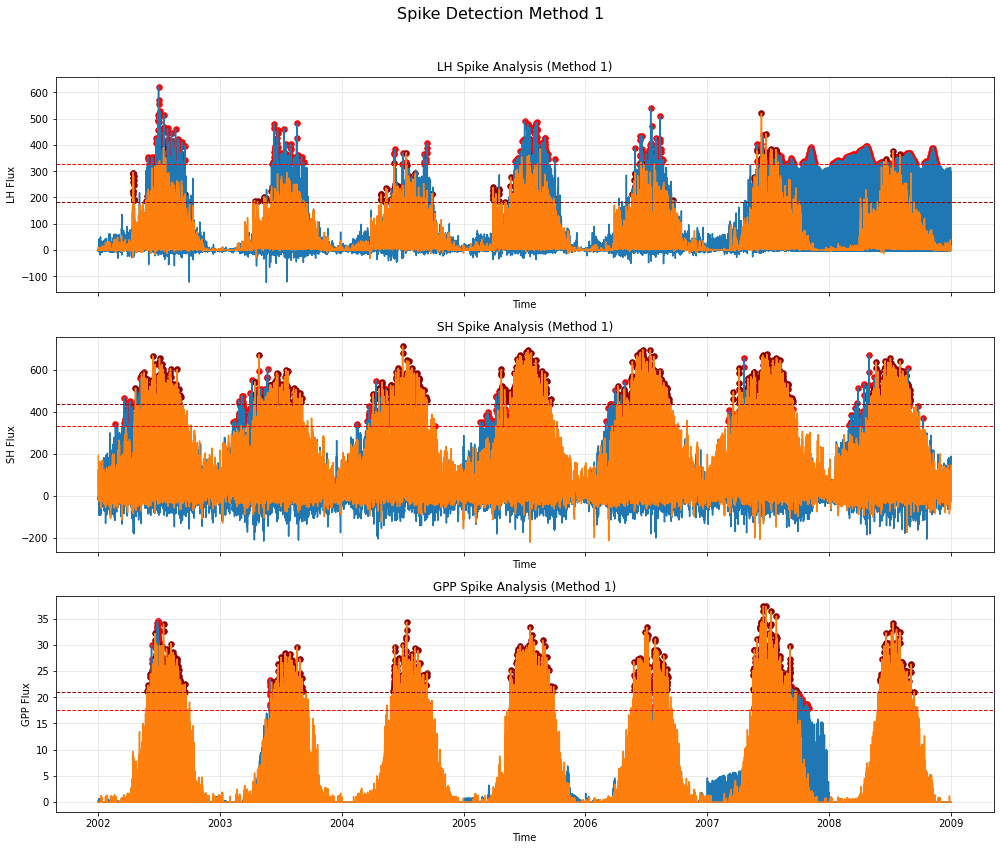

Spike Analysis for LH using method 2:
  Observed: spikes = 1131, Mean amplitude = 357.87
  Modeled:  spikes = 1462, Mean amplitude = 229.18

Spike Analysis for SH using method 2:
  Observed: spikes = 1228, Mean amplitude = 392.19
  Modeled:  spikes = 1487, Mean amplitude = 511.81

Spike Analysis for GPP using method 2:
  Observed: spikes = 1905, Mean amplitude = 20.56
  Modeled:  spikes = 1466, Mean amplitude = 24.15



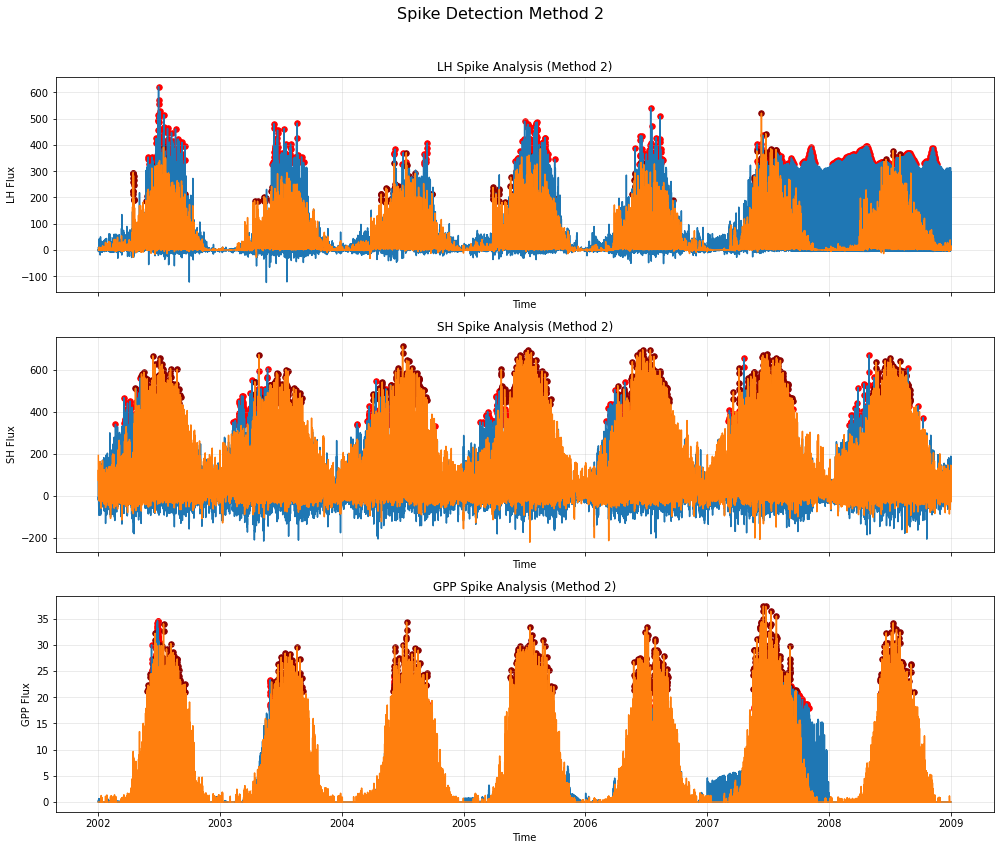

Spike Analysis for LH using method 3:
  Observed: spikes = 15553, Mean amplitude = 184.68
  Modeled:  spikes = 14033, Mean amplitude = 108.18

Spike Analysis for SH using method 3:
  Observed: spikes = 7944, Mean amplitude = 247.20
  Modeled:  spikes = 8482, Mean amplitude = 329.02

Spike Analysis for GPP using method 3:
  Observed: spikes = 24801, Mean amplitude = 5.92
  Modeled:  spikes = 22552, Mean amplitude = 8.62



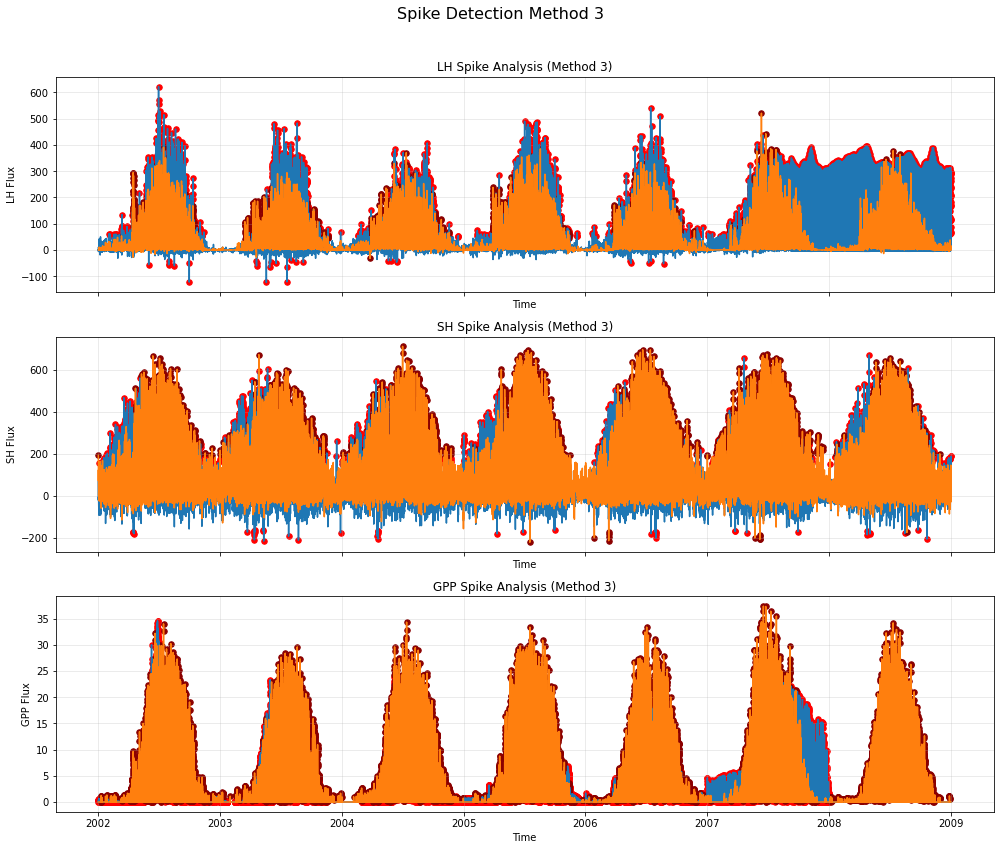

Spike Analysis for LH using method 4:
  Observed: spikes = 285, Mean amplitude = 60.82
  Modeled:  spikes = 146, Mean amplitude = 61.49

Spike Analysis for SH using method 4:
  Observed: spikes = 165, Mean amplitude = 190.82
  Modeled:  spikes = 67, Mean amplitude = 244.28

Spike Analysis for GPP using method 4:
  Observed: spikes = 18, Mean amplitude = 8.55
  Modeled:  spikes = 68, Mean amplitude = 1.23



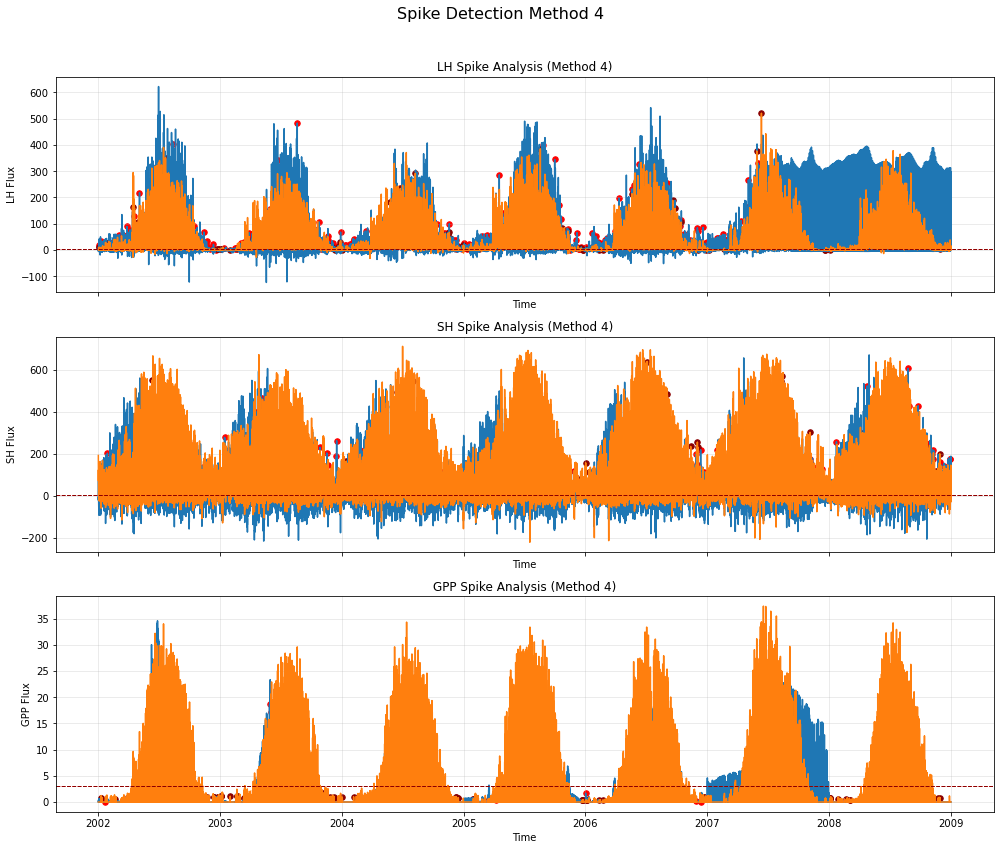

Spike Analysis for LH using method 5:
  Observed: spikes = 614, Mean amplitude = 289.62
  Modeled:  spikes = 614, Mean amplitude = 268.05

Spike Analysis for SH using method 5:
  Observed: spikes = 604, Mean amplitude = 314.61
  Modeled:  spikes = 613, Mean amplitude = 506.46

Spike Analysis for GPP using method 5:
  Observed: spikes = 612, Mean amplitude = 23.33
  Modeled:  spikes = 601, Mean amplitude = 26.86



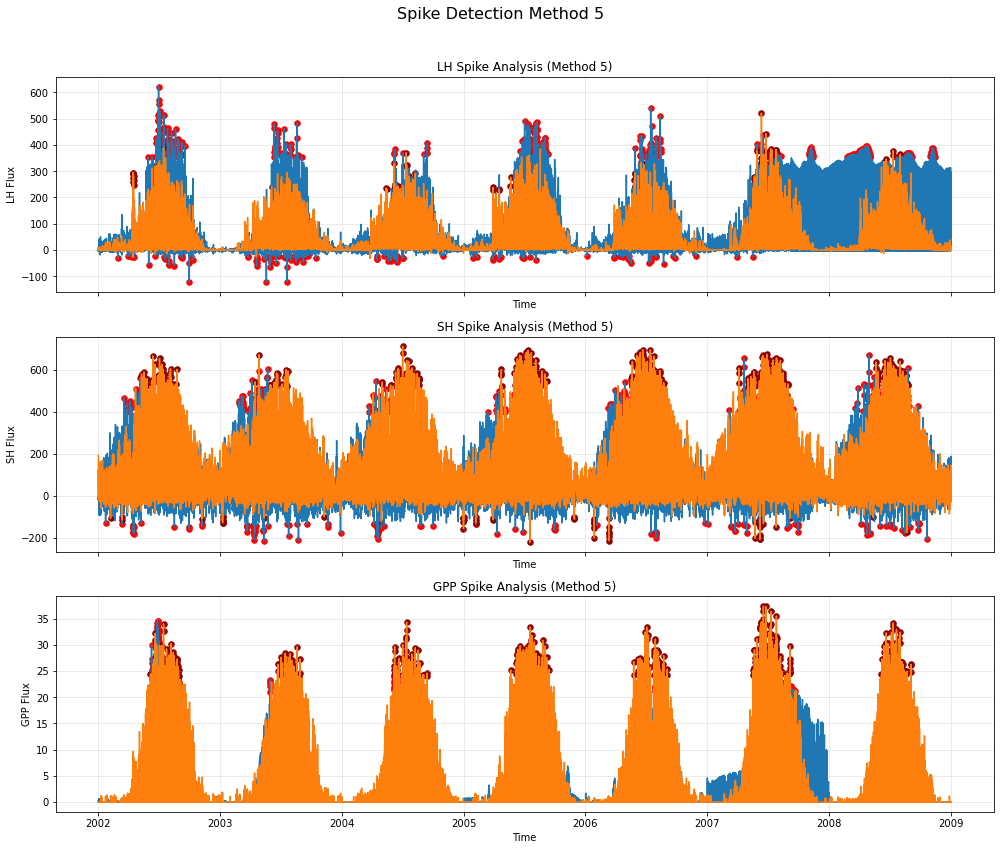

Spike Analysis for LH using method 6:
  Observed: spikes = 10211, Mean amplitude = 73.29
  Modeled:  spikes = 6693, Mean amplitude = 100.15

Spike Analysis for SH using method 6:
  Observed: spikes = 11363, Mean amplitude = 66.90
  Modeled:  spikes = 9913, Mean amplitude = 117.89

Spike Analysis for GPP using method 6:
  Observed: spikes = 1856, Mean amplitude = 11.75
  Modeled:  spikes = 3984, Mean amplitude = 16.25



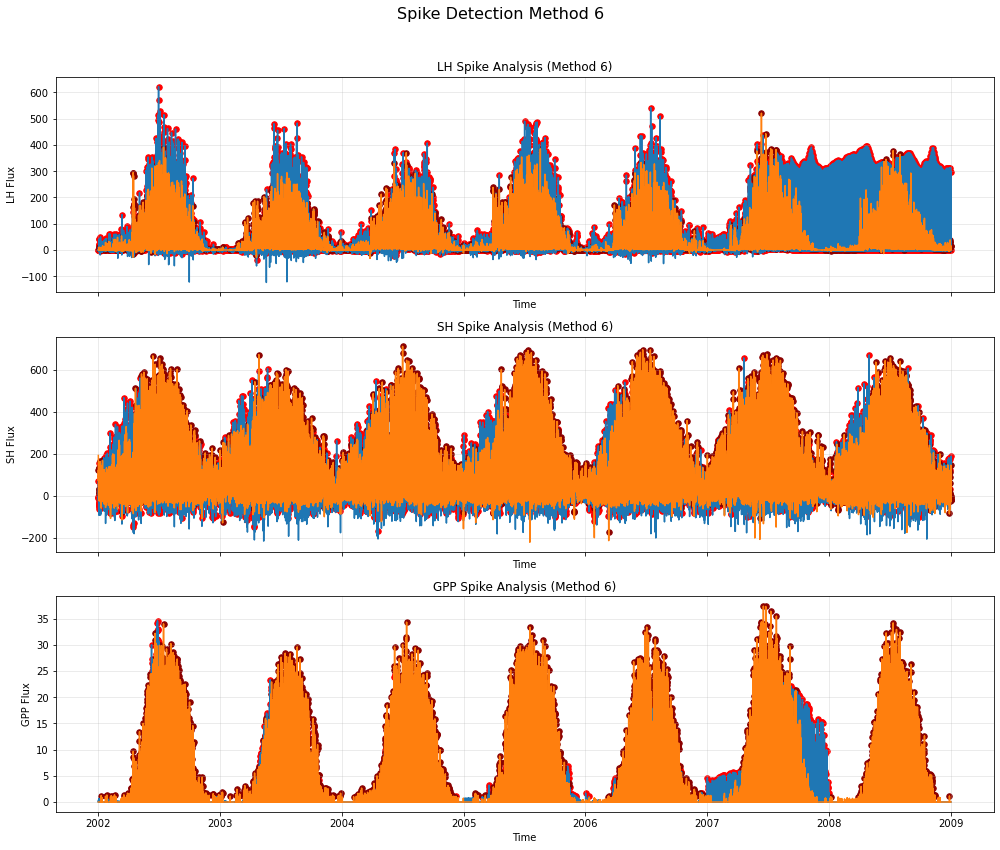

In [6]:
def main():
    # 文件路径（请根据实际情况调整）
    FLUX_FILE = "../obs/US-Syv_2002010106_2009010105_hur_Flux.nc"
    MOD_FILE  = "../US-Syv_01/2002010107.LDASOUT_DOMAIN1"
    
    # 载入观测数据
    df_obs_lh = process_latent_heat_data(FLUX_FILE)
    df_obs_sh = process_sensible_heat_data(FLUX_FILE)
    df_obs_gpp = process_gpp_data(FLUX_FILE)
    
    # 载入模型数据
    df_mod_lh, df_mod_sh, df_mod_psn = process_model_data(MOD_FILE)
    
    # 限制观测数据的时间范围与模型数据一致
    max_time = min(df_mod_lh.index.max(), df_mod_sh.index.max(), df_mod_psn.index.max())
    df_obs_lh = df_obs_lh[df_obs_lh.index <= max_time]
    df_obs_sh = df_obs_sh[df_obs_sh.index <= max_time]
    df_obs_gpp = df_obs_gpp[df_obs_gpp.index <= max_time]
    
    # 循环使用方法 1 到 6 绘制图像，每种方法生成一个包含 3 个子图的图
    for spike_method in range(1, 7):
        # 如有需要，可在 spike_kwargs 中设置额外参数，例如：
        # spike_kwargs = {'threshold': 3.0} 或 {'prominence': 1.0} 等
        spike_kwargs = {}  
        
        # 创建一个包含 3 个子图（纵向排列）的图像
        fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
        
        # 子图 1: 潜热 (LH)
        plot_variable_spikes(axes[0],
                             obs_series=df_obs_lh['Qle_cor'],
                             mod_series=df_mod_lh['LH'],
                             var_name="LH",
                             spike_method=spike_method,
                             spike_kwargs=spike_kwargs,
                             show_labels=True)
        
        # 子图 2: 显热 (SH)
        plot_variable_spikes(axes[1],
                             obs_series=df_obs_sh['Qh'],
                             mod_series=df_mod_sh['HFX'],
                             var_name="SH",
                             spike_method=spike_method,
                             spike_kwargs=spike_kwargs,
                             show_labels=False)
        
        # 子图 3: GPP（观测用 GPP，模型用 PSN）
        plot_variable_spikes(axes[2],
                             obs_series=df_obs_gpp['GPP'],
                             mod_series=df_mod_psn['PSN'],
                             var_name="GPP",
                             spike_method=spike_method,
                             spike_kwargs=spike_kwargs,
                             show_labels=False)
        
        # 设置整个图的标题，并调整布局
        fig.suptitle(f"Spike Detection Method {spike_method}", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        
        # 显示图像（在 Jupyter Notebook 中每次 plt.show() 都会输出一个图）
        plt.show()

if __name__ == '__main__':
    main()


# conclusion